<a href="https://colab.research.google.com/github/WittyTheMighty/ML-kaggle/blob/main/final_3_decembre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Final Kaggle competition ML

In [2]:
 from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%%capture
!pip install wandb --upgrade

This is how we can identify the model.

In [4]:
#Exemple d'utilisation 

# import wandb
# # At the top of your training script, start a new run
# wandb.init(project="test-project", entity="xabjuwplb")
# # Capture a dictionary of hyperparameters with config
# wandb.config = {
#   "learning_rate": 0.001,
#   "epochs": 100,
#   "batch_size": 128
# }

# # Log metrics inside your training loop to visualize model performance
# wandb.log({"loss": loss})

# # Optional
# wandb.watch(model)


###Import: 

In [5]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import torch as torch
import torchvision as  tv
import torch.nn as nn
import torchvision.transforms as transforms
import os
import pandas as pd
import pickle as pkl
from matplotlib import cm
from PIL import Image
import torch.optim as optim
import torch.nn as nn 
import torch.nn.functional as F 
import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import csv
import scipy as sp
import copy

import numpy as np
from sklearn.decomposition import PCA
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.utils as vutils
device = torch.device('cuda')

from sklearn.utils import shuffle
import os
import random

import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import wandb
from sklearn.metrics import f1_score
# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# Device configuration


######Weigth and biais imports

To track our model we use weights and biaises a plateform that allow us to track the data in the pipeline.

In [6]:
#PATH = './drive/MyDrive/ML-Kaggle/'
PATH = "/content/drive/MyDrive/ML-Kaggle/"
# PATH = '../data/'

#Load
x_data = np.array(pkl.load(open(PATH+'x_train.pkl', 'rb')))
y_data = np.array(pkl.load(open(PATH+'y_train.pkl', 'rb')))

x_test_submission =  np.array(pkl.load(open(PATH+'x_test.pkl', 'rb')))



In [7]:
x_train = x_data[:10000]
y_train = y_data[:10000]

#Before submit we test the model on this subsection of the dataset without augmented data
x_valid = x_data[10001:]
y_valid = y_data[10001:]

assert len(x_train) == len(y_train)
assert len(x_valid) == len(y_valid)

In [8]:
labels = np.unique(y_train)
labels = dict(zip(labels, range(len(labels))))

In [9]:
labels = np.unique(y_valid)
labels=dict(zip(labels, range(len(labels))))

---

## Preprocessing

####Data augmentation from strach

In [10]:
#First preprocessing step 

#Utilitary function for geometric preprocessing
# def flip_verticaly(X):
#     flipped_image = copy.deepcopy(rotate90(X))
#     for idx,channel in enumerate(flipped_image):
#         flipped_image[idx]= np.fliplr(channel)

#     return rotate(flipped_image, 270)


def flip_horizontaly(X):
    flipped_image = copy.deepcopy(X)
    flipped_image= np.fliplr(flipped_image)

    return flipped_image

def rotate90(X):
    rot90_img = copy.deepcopy(X)
    rot90_img= np.rot90(rot90_img)
    return rot90_img

def rotate(X,degree):
    rot_img = copy.deepcopy(X)
    rot_img= sp.ndimage.rotate(rot_img, degree, reshape=False)
    return rot_img

#An adaptation from:
# https://stackoverflow.com/questions/37119071/scipy-rotate-and-zoom-an-image-without-changing-its-dimensions
def clipped_zoom(img, zoom_factor):

    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = sp.ndimage.zoom(img, zoom_tuple)

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = sp.ndimage.zoom(img[top:top+zh, left:left+zw], zoom_tuple)

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

def blur(X,blur_factor):
    blur_img = copy.deepcopy(X)
    blur_img= sp.ndimage.gaussian_filter(blur_img, sigma=blur_factor)
    return blur_img


In [11]:
zoom_factors = [1.1, 1.3, 1.5]
x_train_zoomed_vertical = np.array([clipped_zoom(x,np.random.choice(zoom_factors)) for x in x_train])
x_train_zoomed_horizontal = np.array([rotate(clipped_zoom(rotate90(x),np.random.choice(zoom_factors)),270) for x in x_train])

In [12]:
x_train_rotated = np.array([rotate(x,round(np.random.random()*360)) for x in x_train])

In [13]:
x_train_flipped_horizontally = np.array([flip_horizontaly(x) for x in x_train])

In [14]:
augmented_x_train = np.concatenate([x_train, x_train_zoomed_horizontal, x_train_zoomed_vertical, x_train_rotated, x_train_flipped_horizontally], axis=0)

In [15]:
augmented_y_train = np.concatenate([y_train]*5)
augmented_y_train.shape

X = np.array([[1., 0.], [2., 1.], [0., 0.]])
y = np.array([0, 1, 2])

X_train, y_train= shuffle(augmented_x_train, augmented_y_train, random_state=0)

In [16]:
# SAVE AUGMENTED TRAINING SET
pkl.dump(augmented_x_train,open(PATH+'x_train_aug.pkl', 'wb'))
pkl.dump(augmented_y_train,open(PATH+'y_train_aug.pkl', 'wb'))

In [17]:
# LOAD AUGMENTED TRAINING SET
x_train = pkl.load(open(PATH+'x_train_aug.pkl', 'rb'))
y_train = pkl.load(open(PATH+'y_train_aug.pkl', 'rb'))

###Normalisation

From strach not used yet. We use pytorch normalize function.


In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

def standardize(data):
    standardized_data = []
    scaler = StandardScaler()
    for img in data:
        scaler = scaler.fit(img)
        standadized_data.append(scaler.transform(img))
    return np.array(standardized_data)

def normalize(data):
    normalized_data = []
    normalizer = Normalizer()
    for img in data:
        normalizer = normalizer.fit(img)
        normalized_data.append(normalizer.transform(img))
    return np.array(normalized_data)




In [19]:

# x_train_normalize = normalize(x_train)

# #Todo : Normaliser les données de tests

# x_test_set = x_train_normalize[:3000]
# y_test_set = y_train[:3000]

# x_train = x_train_normalize[3000:]
# y_train = y_train[3000:]

# assert y_train.shape[0] == x_train.shape[0]
# assert y_test_set.shape[0] == x_test_set.shape[0]

---
## Models

This is all the model we used in our expirements.

##### Inspired AlexNet model

In [20]:

class AlexNet(nn.Module):
    def __init__(self): 
        super().__init__()
        print("AlexNet")
        self.conv1 = nn.Conv2d(1,25,5)
        self.batchNorm2d1 = nn.BatchNorm2d(25,momentum=0.95)
        # we use the maxpool multiple times, but define it once
        self.pool = nn.MaxPool2d(2, 2)
        # in_channels = 6 because self.conv1 output 6 channel
        self.conv2 = nn.Conv2d(25, 50,5)
        self.batchNorm2d2 = nn.BatchNorm2d(50,momentum=0.95)
        self.conv3 = nn.Conv2d(50 ,100,3)
        self.batchNorm2d3 = nn.BatchNorm2d(100,momentum=0.95)
        # 5*5 comes from the dimension of the last convnet layer
        self.fc1 = nn.Linear(100*9*9, 480) 
        self.fc2 = nn.Linear(480, 240)
        self.fc3 = nn.Linear(240, 120)
        self.fc4 = nn.Linear(120, 11)
        
    def forward(self, x): 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.batchNorm2d1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.batchNorm2d2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.batchNorm2d3(x)
        x = x.view(-1, 100*9*9)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  # no activation on final layer 
        return x


class AlexNetv2(nn.Module): 
    def __init__(self): 
        super().__init__()
        print("AlexNetv2")
        self.convolution = nn.Sequential(
            nn.Conv2d(1, 48,7), #in, out, kernel_size, stride,padding
            nn.MaxPool2d(2,stride=2), #kernel_size
            nn.ReLU(),
            nn.BatchNorm2d(48),
            #Layer 2
            nn.Conv2d(48, 128,5,stride=2), #(45-5)/2 +1 = 21
            nn.MaxPool2d(3,2),
            nn.ReLU(),
            nn.BatchNorm2d(128,momemtum=0.),
            nn.Conv2d(128, 192, 5,padding=2), 
            nn.ReLU(),
            nn.Conv2d(192, 192, 3,padding=1), #(39-3+1)/1 =37
            nn.ReLU(),
            nn.Conv2d(192, 128, 3, 1), # 35
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1), 
            nn.MaxPool2d(2,stride=2),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            #3200 = 5 * 5 *128
            nn.Linear(128*3*3, 4096),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(4096, 11),
        )
        
    def forward(self, x): 
        x = self.convolution(x)
        x = x.view(-1,128*3*3)
        x = self.classifier(x)
        return x

#3 convolution layer
class AlexNetv3(nn.Module): 
    def __init__(self): 
        super().__init__()
        print("AlexNetv3")
        self.convolution = nn.Sequential(
            nn.Conv2d(1, 48,7), #in, out, kernel_size, stride,padding
            nn.MaxPool2d(2,stride=2), #kernel_size
            nn.ReLU(),
            nn.BatchNorm2d(48),
            #Layer 2
            nn.Conv2d(48, 128,5,stride=3), #(45-5)/2 +1 = 21
            nn.MaxPool2d(3,2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 192, 5,padding=1), 
            nn.ReLU(),
        )

        self.classifier = nn.Sequential(
            #3200 = 5 * 5 *128
            nn.Linear(192*4*4, 4096),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(4096, 11),
        )
        
    def forward(self, x):
        print(x.shape)
        x = self.convolution(x)
        x = x.view(-1,192*4*4)
        x = self.classifier(x)
        return x
    


    



#### Inspired ResNet

Adaptation from pytorch model
Original papper :<br> [1] He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).
(https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf) <br>
[2] Identity mapping: He, K., Zhang, X., Ren, S., & Sun, J. (2016, October). Identity mappings in deep residual networks. In European conference on computer vision (pp. 630-645). Springer, Cham.
 (https://arxiv.org/pdf/1603.05027.pdf) <br>
 [3] Sun, L. (2016). Resnet on tiny imagenet. Submitted on, 14. 
 (https://arxiv.org/abs/1904.10429)

 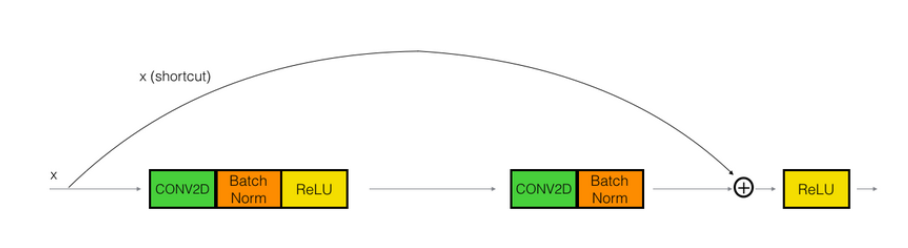

 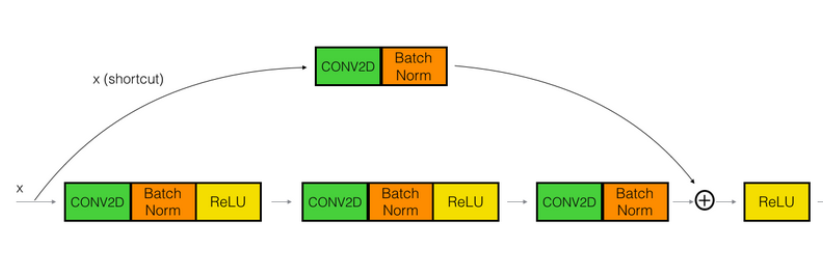

** Represention of residual ConvulutionBlock** <br>

[Source image: https://machinelearningknowledge.ai/keras-implementation-of-resnet-50-architecture-from-scratch/#Architecture_of_ResNet

In [227]:
#Each block contains 2 convolution

class IdentityBlock(nn.Module):

    def __init__(self, in_channels, out_channels,kernel_filter,stride=1):
        super(IdentityBlock,self).__init__()
        self.x_residual = None
        self.block = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_filter,padding="same"),
            nn.BatchNorm2d(out_channels,momentum=0.9),
            nn.ReLU(),
            nn.Conv2d(out_channels,out_channels,kernel_filter,padding="same"),
            nn.BatchNorm2d(out_channels,momentum=0.9),
        )

    def forward(self,x):
        self.x_residual = x
        x = self.block(x)
        x +=self.x_residual
        x = nn.ReLU()(x)
        return x

class ConvulutionBlock(nn.Module):

    
    def __init__(self, in_channels, out_channels,kernel_filter,stride_=1):
        super(ConvulutionBlock,self).__init__()
        self.x_residual = nn.Sequential(
             nn.Conv2d(in_channels,out_channels,kernel_filter,stride=stride_),
             nn.BatchNorm2d(out_channels),
        )
        self.block = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_filter,stride=stride_),
            nn.BatchNorm2d(out_channels,momentum=0.9),
            nn.ReLU(),
            nn.Conv2d(out_channels,out_channels,kernel_filter,padding="same"),
            nn.BatchNorm2d(out_channels,momentum=0.9),

        )

    def forward(self,x):
        x_residual = self.x_residual(x)
        x = self.block(x) + x_residual
        x= nn.ReLU()(x)
        return x

class IdentityBlock3Layers(nn.Module):

    def __init__(self, in_channels, out_channels,kernel_filter,stride=1):
        super(IdentityBlock3Layers,self).__init__()
        self.x_residual = None
        self.block = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_filter,padding="same"),
            nn.BatchNorm2d(out_channels,momentum=0.9),
            nn.ReLU(),
            nn.Conv2d(out_channels,out_channels,kernel_filter,padding="same"),
            nn.BatchNorm2d(out_channels,momentum=0.9),
            nn.Conv2d(out_channels,out_channels,kernel_filter,padding="same"),
            nn.BatchNorm2d(out_channels,momentum=0.9),
        )

    def forward(self,x):
        self.x_residual = x
        x = self.block(x)
        x +=self.x_residual
        x = nn.ReLU()(x)
        return x

class ConvulutionBlock3Layer(nn.Module):

    
    def __init__(self, in_channels, out_channels,kernel_filter,stride_=1):
        super(ConvulutionBlock3Layer,self).__init__()
        self.x_residual = nn.Sequential(
             nn.Conv2d(in_channels,out_channels,kernel_filter,stride=stride_),
             nn.BatchNorm2d(out_channels),
        )
        self.block = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_filter,stride=stride_),
            nn.BatchNorm2d(out_channels,momentum=0.9),
            nn.ReLU(),
            nn.Conv2d(out_channels,out_channels,kernel_filter,padding="same"),
            nn.BatchNorm2d(out_channels,momentum=0.9),
            nn.Conv2d(out_channels,out_channels,kernel_filter,padding="same"),
            nn.BatchNorm2d(out_channels,momentum=0.9),

        )

    def forward(self,x):
        x_residual = self.x_residual(x)
        x = self.block(x) + x_residual
        x= nn.ReLU()(x)
        return x



class ResNet18(nn.Module):

    def __init__(self):
        super(ResNet18,self).__init__()
        #1
        #7x7 conv, 64 /2
        self.resnet = nn.ModuleList([nn.Conv2d(1,32,7,stride=1)]) #2 96x96x1 -> size = 92x92x64
        
        self.resnet.append(nn.MaxPool2d(2,stride=2)) #2 size = 92x92x64-> size = 46x46x32
        # 
        self.resnet.append(IdentityBlock(32,32,3)) #
        self.resnet.append(IdentityBlock(32,32,3)) #
        self.resnet.append(IdentityBlock(32,32,3)) #
                           
        self.resnet.append(ConvulutionBlock(32,64,3,stride_=2)) 
                          
        self.resnet.append(IdentityBlock(64,64,3,stride = 1)) 
        self.resnet.append(IdentityBlock(64,64,3,stride = 1)) 
        self.resnet.append(IdentityBlock(64,64,3,stride = 2)) 
                           
        self.resnet.append(ConvulutionBlock(64,128,3,stride_ =2 ))
        self.resnet.append(IdentityBlock(128,128,3,stride = 1))
        self.resnet.append(IdentityBlock(128,128,3,stride = 1))
        self.resnet.append(ConvulutionBlock(128,512,3,stride_ =2))
        self.resnet.append(ConvulutionBlock(512,512,3,stride_ =1))
        self.resnet.append(nn.AvgPool2d(2))


        self.resnet_sequential = nn.Sequential(*self.resnet)

        self.classifier = nn.Sequential(
            #3200 = 5 * 5 *128
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 11),
        )
                           
    
    def forward(self,x):
        x = self.resnet_sequential(x)
        x = x.view(-1,512)
        self.classifier(x)
        return x

class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50,self).__init__()
        print("ResNet50")
        #1
        #7x7 conv, 64 /2
        self.resnet = nn.ModuleList([nn.Conv2d(1,32,7,stride=1)]) #2 96x96x1 -> size = 92x92x64
        
        self.resnet.append(nn.MaxPool2d(2,stride=2)) #2 size = 92x92x64-> size = 46x46x32
        # 
        self.resnet.append(IdentityBlock3Layers(32,32,3)) #
        self.resnet.append(IdentityBlock3Layers(32,32,3)) #
        self.resnet.append(IdentityBlock3Layers(32,32,3)) #
                           
        self.resnet.append(ConvulutionBlock3Layer(32,64,3,stride_=2)) 
                          
        self.resnet.append(IdentityBlock3Layers(64,64,3,stride = 1)) 
        self.resnet.append(IdentityBlock3Layers(64,64,3,stride = 1)) 
        self.resnet.append(IdentityBlock3Layers(64,64,3,stride = 2)) 
                           
        self.resnet.append(ConvulutionBlock3Layer(64,128,3,stride_ =2 ))
        self.resnet.append(IdentityBlock(128,128,3,stride = 1))
        self.resnet.append(IdentityBlock(128,128,3,stride = 1))
        self.resnet.append(ConvulutionBlock3Layer(128,512,3,stride_ =2))
        self.resnet.append(ConvulutionBlock3Layer(512,512,3,stride_ =1))
        self.resnet.append(nn.AvgPool2d(2))


        self.resnet_sequential = nn.Sequential(*self.resnet)

        self.classifier = nn.Sequential(
            #3200 = 5 * 5 *128
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 11),
        )
                             
    def forward(self,x):
        x = self.resnet_sequential(x)
        x = x.view(-1,512)
        self.classifier(x)
        return x


class ResNet75(nn.Module):
    def __init__(self):
        super(ResNet75,self).__init__()
        print("ResNet75")
        #1
        #7x7 conv, 64 /2
        self.resnet = nn.ModuleList([nn.Conv2d(1,64,7,stride=1)]) #2 96x96x1 -> size = 92x92x64
        
        self.resnet.append(nn.MaxPool2d(2,stride=2)) #2 size = 92x92x64-> size = 46x46x32
        # 
        self.resnet.append(IdentityBlock3Layers(64,64,3)) #
        self.resnet.append(IdentityBlock3Layers(64,64,3)) #
        self.resnet.append(IdentityBlock3Layers(64,64,3)) #
        self.resnet.append(IdentityBlock3Layers(64,64,3)) #
        self.resnet.append(IdentityBlock3Layers(64,64,3)) #
        self.resnet.append(IdentityBlock3Layers(64,64,3)) #
                           
        self.resnet.append(ConvulutionBlock3Layer(64,128,3,stride_=2)) 
                          
        self.resnet.append(IdentityBlock3Layers(128,128,3,stride = 1)) 
        self.resnet.append(IdentityBlock3Layers(128,128,3,stride = 1)) 
        self.resnet.append(IdentityBlock3Layers(128,128,3,stride = 1)) 
        self.resnet.append(IdentityBlock3Layers(128,128,3,stride = 1)) 
        self.resnet.append(IdentityBlock3Layers(128,128,3,stride = 1)) 
        self.resnet.append(IdentityBlock3Layers(128,128,3,stride = 2)) 
                           
        self.resnet.append(ConvulutionBlock3Layer(128,256,3,stride_ =2 ))
        self.resnet.append(IdentityBlock(256,256,3,stride = 1))
        self.resnet.append(IdentityBlock(256,256,3,stride = 1))
        self.resnet.append(IdentityBlock(256,256,3,stride = 1))

        self.resnet.append(ConvulutionBlock3Layer(256,512,3,stride_ =2))

        self.resnet.append(IdentityBlock(512,512,3,stride = 1)) 
        self.resnet.append(IdentityBlock(512,512,3,stride = 1)) 
        self.resnet.append(IdentityBlock(512,512,3,stride = 1)) 
        self.resnet.append(IdentityBlock(512,512,3,stride = 1)) 
        self.resnet.append(IdentityBlock(512,512,3,stride = 1)) 
        self.resnet.append(ConvulutionBlock3Layer(512,512,3,stride_ =1))
        self.resnet.append(nn.AvgPool2d(2))


        self.resnet_sequential = nn.Sequential(*self.resnet)

        self.classifier = nn.Sequential(
            #3200 = 5 * 5 *128
            nn.Linear(512, 11),

        )
                             
    def forward(self,x):
        x = self.resnet_sequential(x)
        x = x.view(-1,512)
        self.classifier(x)
        return x





class ResNet12(nn.Module):

    def __init__(self):
        super(ResNet12,self).__init__()
        print("ResNet12")
        #Input 96x96
        self.resnet = nn.ModuleList([nn.Conv2d(1,64,3,stride=2)])
        # pool /2
        # 48x48
        self.resnet.append(nn.MaxPool2d(3,stride=2))
        # 6x (3x3 conv 64,)
        self.resnet.extend([IdentityBlock(64,64,3) for i in range(10)])

        self.resnet.append(nn.AvgPool2d(4))
        self.resnet_sequential = nn.Sequential(*self.resnet)
        self.classifier = nn.Sequential(
            #3200 = 5 * 5 *128
            nn.Linear(1600, 800),
            nn.ReLU(),
            nn.Linear(800, 400),
            nn.ReLU(),
            nn.Linear(400, 11),
            
        )
    
    def forward(self,x):
        x = self.resnet_sequential(x)
        x = x.view(-1,1600)
        self.classifier(x)
        return x






class ResNet34(nn.Module):

    def __init__(self,):
        super(ResNet34,self).__init__()
        #7x7 conv, 64 /2
        print("RestNet")
        self.resnet = nn.ModuleList([nn.Conv2d(1,64,5,stride = 1)])
        # pool /2
        self.resnet.append(nn.MaxPool2d(2))
        # 6x (3x3 conv 64,)
        self.resnet.extend([IdentityBlock(64,64,3) if i < 5 else nn.Conv2d(64,128,3) for i in range(6)])

        # 6x (3x3 conv 128,)
        self.resnet.append(nn.Conv2d(128,128,3))
        self.resnet.extend([IdentityBlock(128,128,3) for i in range(3)])
        self.resnet.append( nn.Conv2d(128,256,3))

        # 8 x (3x3 conv 256)
        self.resnet.append(nn.Conv2d(256,256,3,padding="same"))
        self.resnet.extend([IdentityBlock(256,256,3) for i in range(5)])
        self.resnet.append(nn.Conv2d(256,512,3))

        self.resnet.append(nn.Conv2d(512,512,3,stride=1))
        self.resnet.extend([IdentityBlock(512,512,3) for i in range(5)])
        self.resnet.append(nn.AvgPool2d(2))

        self.resnet_sequential = nn.Sequential(*self.resnet)
        self.classifier = nn.Sequential(
            #3200 = 5 * 5 *128
            nn.Linear(165888, 16384),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16384, 8192),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(8192, 4096),
            nn.Linear(4096, 11),
        )
    
    def forward(self,x):
        x = self.resnet_sequential(x)
        x = x.view(-1,165888)
        self.classifier(x)
        return x




    






#### Inspired VGG

##Pipeline

For our pipeline we used the pipeline framework weigths and biaises for easy and fast data parameter tracking. All the result of our experiments will be store on the cloud. 

In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cuda')
#device = torch.device("cpu")

from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.utils as vutils

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms."""
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]
        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)
    


#####Custom TensorDataset

In [23]:
#Creating dataloader object
trans = transforms.Compose(
    [transforms.Normalize((0.5), (0.5))]
)


#Training set
x_train_tensor = torch.tensor(x_train,  dtype=torch.float32)[:, None, :, :]
y_train_tensor = torch.tensor(np.array([labels[y] for y in y_train]),  dtype=torch.long)

train_dataset = CustomTensorDataset(tensors=(x_train_tensor, y_train_tensor), transform=trans)





#Validation set
x_valid_tensor = torch.tensor(x_valid,  dtype=torch.float32)[:, None, :, :]
y_valid_tensor = torch.tensor(np.array([labels[y] for y in y_valid]),  dtype=torch.long)

valid_dataset = CustomTensorDataset(tensors=(x_valid_tensor, y_valid_tensor), transform=trans)


In [24]:
train_dataloader = torch.utils.data.DataLoader(train_dataset,  pin_memory = True, batch_size=64, shuffle=True)

####Pipeline implementation
 
If new variable added but them in the config file

```

hyperparam = {
    "training_data": train_data,
    "valid_data": valid_data,
     "label_smoothing":0.2,
    "model":"AlexNet",
    "learning_rate":1e-2,
    "batch_size":64,
    "epochs": 5,

    "k_folds" :5,
    "description":"Setting up momemtum to 0.95"
    }


```


In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [206]:
#This code is an adaptation from Weigth&BiaisesFramework we established a pipeline to track our data : https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch/Simple_PyTorch_Integration.ipynb#scrollTo=bZiTlrNkRKzm&uniqifier=1
def model_pipeline(hyperparameters,training_data,valid_data):
    """"
    "Hyperparameters need to be a dictionary with all the necessary information" Wandb librairie will load the data"
    "into their server."
    """
    # tell wandb to get started
    with wandb.init(entity="xabjuwplb",project="CNN", config=hyperparameters):

        config = wandb.config
        train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=config.batch_size, shuffle=True)
        valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=config.batch_size, shuffle=True)

        # make the model, data, and optimization problem
        model, criterion, optimizer = make(config)
        model.to(device)
        criterion.to(device)
        # and use them to train the model
        train(model, train_dataloader,valid_dataloader, criterion, optimizer, config)

        # and test its final performance
        test(model, valid_dataloader,train_dataloader)
        torch.save(model.state_dict(), PATH)

    return model

def make(config):

    # Make the model
    model = initialize_model(config)

    # Make the loss and optimizer
    criterion = nn.CrossEntropyLoss(label_smoothing=config.label_smoothing)
    optimizer = torch.optim.Adam(
        model.parameters(), lr=config.learning_rate)    
    return model, criterion, optimizer

def make_loaders(config):

    return train_dataloader, valid_dataloader


def initialize_model(config):
    #When implmenting add it to the map
    if config.model == "AlexNet":
        return AlexNet()
    elif config.model == "AlexNetv2":
        return AlexNetv2()
    elif config.model == "AlexNetv3":
        return AlexNetv3()
    elif config.model == "ResNet34":
        return ResNet34()
    elif config.model == "ResNet18":
        return ResNet18()
    elif config.model == "ResNet12":
        return ResNet12()
    elif config.model == "ResNet50":
        return ResNet50()
    elif config.model == "ResNet75":
        return ResNet75()

def train(model, train_loader,valid_loader, criterion, optimizer, config):
    # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, criterion, log="all", log_freq=10)
    # Run training and track with wandb
    total_batches = len(train_loader) * config.epochs
    example_ct = 0  # number of examples seen
    batch_ct = 0
    loss = 0

    scheduler = optim.lr_scheduler. MultiStepLR(optimizer, milestones=[1,2,3], gamma=0.1)

    for epoch in tqdm(range(config.epochs)):
        #Learning rate scheduler for smaller step size

        for _, (image,label) in enumerate(train_loader):
            loss = train_batch(image, label, model, optimizer, criterion)
            valid_loss = valid_batch(valid_loader,model,criterion)
            example_ct +=  len(image)
            batch_ct += 1

            # Report metrics every 25th batch
            if ((batch_ct + 1) % 25) == 0:
                train_log(loss,valid_loss, example_ct, epoch)
        test(model,valid_loader,train_loader)
        torch.save(model.state_dict(), "epoch_"+str(epoch)+config["model"]+".pth")
        scheduler.step()
        print("New learning rate:",scheduler.get_last_lr())
        
        
#
def train_batch(images, labels, model, optimizer, criterion):
    images, labels = images.to(device), labels.to(device)
    
    # Forward pass ➡
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward pass ⬅
    optimizer.zero_grad()
    loss.backward()
    # Step with optimizer
    optimizer.step()
    return loss
def valid_batch(valid_data_load,model,criterion):

    valid_loss = 0
    valid_image,valid_label = next(iter(valid_data_load))

    valid_images, valid_labels = valid_image.to(device), valid_label.to(device)
    # Forward pass ➡
    outputs = model(valid_images)

    valid_loss += criterion(outputs, valid_labels)

    return valid_loss



def test(model, test_loader,train_loader):
    model.eval()

    # Run the model on some test examples
    with torch.no_grad():
        correct, total = 0, 0
        true_y = np.array([])
        predicted_y = np.array([])
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # predicted_y = np.append(predicted_y,predicted.cpu().detach().tolist())
            # true_y = np.append(true_y,labels.cpu().detach().tolist())

        # f1_score_micro = f1_score(true_y,predicted_y,average="micro")
        print(f"Accuracy of the model on the {total} " +
              f"test images: {100 * correct / total}%")

        
        wandb.log({"test_accuracy": correct / total})
    # Run the model on some test examples
    with torch.no_grad():
        correct, total = 0, 0
        true_y =np.array([])
        predicted_y = np.array([])
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # true_y= np.append(true_y,labels.cpu().detach().tolist())
            # predicted_y=np.append(predicted_y,predicted.cpu().detach().tolist())    

        print(f"Accuracy of the model on the {total} " +
              f"training images: {100 * correct / total}%")
        wandb.log({"training_accuracy": correct / total})
        # f1_score_micro = f1_score(true_y,predicted_y,average="micro")
        # print(f"F1 micro score {total} " +
        #       f"training images: {f1_score_micro}")        
        # wandb.log({"training_accuracy": correct / total})


In [28]:
def train_log(loss,valid_loss, example_ct, epoch):
    # Where the magic happens
    wandb.log({"epoch": epoch, "training_loss": loss,"valid_loss":valid_loss}, step=example_ct)
    print(f"Loss after " + str(example_ct).zfill(5) + f" examples: {loss:.3f}")
    print(f"Validation loss after " + str(example_ct).zfill(5) + f" examples: {valid_loss:.3f}")
    

In [29]:
def save_model(epoch,model,optimizer,loss,path):

    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "loss": loss
    }, path)
###
#
def load_model(checkpoints_path):
    checkpoints = torch.load(PATH)
    with wandb.init(entity="xabjuwplb",project="CNN", config=checkpoints):
        config = wandb.config 
        #Initialize
        model = initialize_model(config.model)
        optimizer = nn.CrossEntropyLoss()


        optimizer = optimizer.load_state_dict(config['optimizer_state_dict'])
        checkpoint = torch.load(PATH)
        model.load_state_dict(config['model_state_dict'])
        optimizer.load_state_dict(config['optimizer_state_dict'])
        epoch = config['epoch']
        loss = config['loss']


In [202]:
config = {

    "model":"ResNet75",
    "learning_rate_gamma":0.96,
    "learning_rate":1e-2,
    "label_smoothing":0.1,
    "optimizer": "Adam",
    "batch_size":64,
    "epochs": 15,
    "description": ""
    }


### Running the models

In [228]:
# Build, train and analyze the model with the pipeline
torch.cuda.empty_cache()
model = model_pipeline(config,train_dataset,valid_dataset)

ResNet75


RuntimeError: ignored

#### Soumission

In [ ]:
def make_submission(x_test, network):
    header = ["Id", "class"]
    id_value = 0

    classifications =[]
    for image in x_test:
        image = torch.reshape(image[0], (1,1,96, 96))
        classifications.append([id_value, network(image.float()).argmax(dim=1)[0].item()])
        id_value += 1

    y = PATH+"./submission_Alexnetv2.csv"
    with open(y, 'w', newline='') as work:
        z = csv.writer(work)
        z.writerow(header)
        z.writerows(classifications)

In [ ]:
#loading data
x_test_scalar =  np.array(pkl.load(open(PATH+'x_test.pkl', 'rb')))
x_test = x_test_scalar

x_test = torch.tensor(x_test, dtype=float)[:, None, :, :].to(device)
y_test = torch.tensor(np.array([1 for y in x_test]), dtype=float)

trans = transforms.Compose(
    [transforms.Normalize((0.5), (0.5))]
)
#Transformation
test_dataset = CustomTensorDataset(tensors=(x_test, y_test), transform=trans)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                          shuffle=False)
#Insert model
network = AlexNetv2().to(device)
network.load_state_dict(torch.load('/content/epoch_6AlexNetv2.pth'))
network.eval()

make_submission(test_dataloader, network)